<a href="https://colab.research.google.com/github/juanpablopizarro/duia2021/blob/main/Copy_of_Copia_de_TP1_Modulo3_DUIA_NLP_Pizarro_Casciaro_version2_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico 1 - Casciaro / Pizarro

...


# Instalacion de dependencias

In [ ]:
  !pip install symspellpy
  !pip install wget


     |████████████████████████████████| 2.6 MB 7.4 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9673 sha256=f15e7554c8e6d29d8d3ab111e80b74175df34db3d8abdddad440d3260286d493
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


# Carga de los datos y creación del dataset

Importamos los datos en formato json desde un repositorio público de github y luego importamos pandas para crear y trabajar con el dataset.

In [ ]:
import wget
from os import path
import pandas as pd
from google.colab import drive

# montamos google drive
drive.mount('/content/gdrive/')

# Creamos la carpeta e drive que va a alojar los files con los que vamos a trabajar
from os import makedirs
datasets_folder = '/content/gdrive/My Drive/Colab Notebooks/DUIA/2021/Machine Learning/NLP-TP3'
makedirs(datasets_folder, exist_ok=True)

# bajamos el file de comments de reddit desde github
dataset = dict()
dataset['url'] = 'https://raw.githubusercontent.com/juanpablopizarro/duia2021/main/reddit_comments.json'
dataset['extension'] = '.json'
dataset['filename'] = path.join(datasets_folder, 'dataset' + dataset['extension']) 
if not path.exists(dataset['filename']):  # descargar solamente si no existe
  wget.download(dataset['url'], dataset['filename'])
else:
  print('El archivo {} ya existe.'.format(dataset['filename']))

# bajamos el file de contractions desde github
contractions = dict()
contractions['url'] = 'https://raw.githubusercontent.com/juanpablopizarro/duia2021/main/contractions.json'
contractions['extension'] = '.json'
contractions['filename'] = path.join(datasets_folder, 'contractions' + contractions['extension']) 
if not path.exists(contractions['filename']):  # descargar solamente si no existe
  wget.download(contractions['url'], contractions['filename'])
else:
  print('El archivo {} ya existe.'.format(contractions['filename']))

Mounted at /content/gdrive/
El archivo /content/gdrive/My Drive/Colab Notebooks/DUIA/2021/Machine Learning/NLP-TP3/dataset.json ya existe.
El archivo /content/gdrive/My Drive/Colab Notebooks/DUIA/2021/Machine Learning/NLP-TP3/contractions.json ya existe.


# Funciones del pipeline
En la siguiente celda definimos las funciones que vamos a usar en el pipeline dentro de ellas estan:

 * eliminacion de mas de un espacio en blanco consecutivos
 * eliminacion de signos de puntuacion
 * reemplazo de URL's
 * simplificacion de puntuacion (por ejemplo reemplazar !!! por !)
 * normalizacion de contracciones usando una lista que bajamos de internet (wikipedia)
 * correccion de ortografia
 * reduccion de exageraciones (por ejemplo hooooola por hola)
 * lematizacion
 

In [ ]:
from symspellpy.symspellpy import SymSpell, Verbosity
import pkg_resources
import re, string, json
import spacy
from tqdm.notebook import tqdm

def simplify_punctuation_and_whitespace(sentence_list):
    norm_sents = []
    print("Normalizing whitespaces and punctuation")
    for sentence in tqdm(sentence_list):
        sent = _replace_urls(sentence)
        sent = _simplify_punctuation(sentence)
        sent = _normalize_whitespace(sent)
        norm_sents.append(sent)
    return norm_sents

def _replace_urls(text):
    url_regex = r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
    text = re.sub(url_regex, "<URL>", text)
    return text

def _simplify_punctuation(text):
    """
    This function simplifies doubled or more complex punctuation. The exception is '...'.
    """
    corrected = str(text)
    corrected = re.sub(r'([!?,;])\1+', r'\1', corrected)
    corrected = re.sub(r'\.{2,}', r'...', corrected)
    return corrected

def _normalize_whitespace(text):
    """
    This function normalizes whitespaces, removing duplicates.
    """
    corrected = str(text)
    corrected = re.sub(r"//t",r"\t", corrected)
    corrected = re.sub(r"( )\1+",r"\1", corrected)
    corrected = re.sub(r"(\n)\1+",r"\1", corrected)
    corrected = re.sub(r"(\r)\1+",r"\1", corrected)
    corrected = re.sub(r"(\t)\1+",r"\1", corrected)
    return corrected.strip(" ")

def normalize_contractions(sentence_list):
    contraction_list = json.loads(open(contractions['filename'], 'r').read())
    norm_sents = []
    print("Normalizing contractions")
    for sentence in tqdm(sentence_list):
        norm_sents.append(_normalize_contractions_text(sentence, contraction_list))
    return norm_sents

def _normalize_contractions_text(text, contractions):
    """
    This function normalizes english contractions.
    """
    new_token_list = []
    token_list = text.split()
    for word_pos in range(len(token_list)):
        word = token_list[word_pos]
        first_upper = False
        if word[0].isupper():
            first_upper = True
        if word.lower() in contractions:
            replacement = contractions[word.lower()]
            if first_upper:
                replacement = replacement[0].upper()+replacement[1:]
            replacement_tokens = replacement.split()
            if len(replacement_tokens)>1:
                new_token_list.append(replacement_tokens[0])
                new_token_list.append(replacement_tokens[1])
            else:
                new_token_list.append(replacement_tokens[0])
        else:
            new_token_list.append(word)
    sentence = " ".join(new_token_list).strip(" ")
    return sentence

def spell_correction(sentence_list):
    max_edit_distance_dictionary= 3
    prefix_length = 4
    spellchecker = SymSpell(max_edit_distance_dictionary, prefix_length)
    dictionary_path = pkg_resources.resource_filename(
        "symspellpy", "frequency_dictionary_en_82_765.txt")
    bigram_path = pkg_resources.resource_filename(
        "symspellpy", "frequency_bigramdictionary_en_243_342.txt")
    spellchecker.load_dictionary(dictionary_path, term_index=0, count_index=1)
    spellchecker.load_bigram_dictionary(dictionary_path, term_index=0, count_index=2)
    norm_sents = []
    print("Spell correcting")
    for sentence in tqdm(sentence_list):
        norm_sents.append(_spell_correction_text(sentence, spellchecker))
    return norm_sents

def _spell_correction_text(text, spellchecker):
    """
    This function does very simple spell correction normalization using pyspellchecker module. It works over a tokenized sentence and only the token representations are changed.
    """
    if len(text) < 1:
        return ""
    #Spell checker config
    max_edit_distance_lookup = 2
    suggestion_verbosity = Verbosity.TOP # TOP, CLOSEST, ALL
    #End of Spell checker config
    token_list = text.split()
    for word_pos in range(len(token_list)):
        word = token_list[word_pos]
        if word is None:
            token_list[word_pos] = ""
            continue
        if not '\n' in word and word not in string.punctuation and not is_numeric(word) and not (word.lower() in spellchecker.words.keys()):
            suggestions = spellchecker.lookup(word.lower(), suggestion_verbosity, max_edit_distance_lookup)
            #Checks first uppercase to conserve the case.
            upperfirst = word[0].isupper()
            #Checks for correction suggestions.
            if len(suggestions) > 0:
                correction = suggestions[0].term
                replacement = correction
            #We call our _reduce_exaggerations function if no suggestion is found. Maybe there are repeated chars.
            else:
                replacement = _reduce_exaggerations(word)
            #Takes the case back to the word.
            if upperfirst:
                replacement = replacement[0].upper()+replacement[1:]
            word = replacement
            token_list[word_pos] = word
    return " ".join(token_list).strip()

def _reduce_exaggerations(text):
    """
    Auxiliary function to help with exxagerated words.
    Examples:
        woooooords -> words
        yaaaaaaaaaaaaaaay -> yay
    """
    correction = str(text)
    #TODO work on complexity reduction.
    return re.sub(r'([\w])\1+', r'\1', correction)

def is_numeric(text):
    for char in text:
        if not (char in "0123456789" or char in ",%.$"):
            return False
    return True

def lemmatize(sentence_list):
    nlp = spacy.load('en')
    new_norm=[]
    print("Lemmatizing Sentences")
    for sentence in tqdm(sentence_list):
        new_norm.append(_lemmatize_text(sentence, nlp).strip())
    return new_norm

def _lemmatize_text(sentence, nlp):
    sent = ""
    doc = nlp(sentence)
    for token in doc:
        if '@' in token.text:
            sent+=" @MENTION"
        elif '#' in token.text:
            sent+= " #HASHTAG"
        else:
            sent+=" "+token.lemma_
    return sent


# Pipeline
En la siguiente celda definimos el pipeline. El pipelie es la ejecucion de las funciones anteriormente definidas en un orden especifico.

In [ ]:
def normalization_pipeline(sentences):
    print("##############################")
    print("Starting Normalization Process")
    sentences = simplify_punctuation_and_whitespace(sentences)
    sentences = normalize_contractions(sentences)
    sentences = spell_correction(sentences)
    sentences = lemmatize(sentences)
    print("Normalization Process Finished")
    print("##############################")
    return sentences

Ahora ejecutamos el pipeline:

In [ ]:
import pandas as pd

raw_ds = pd.read_json(dataset['filename'])
print('Tamaño del dataset original: {}\n'.format(len(raw_ds)))
raw_ds = raw_ds[raw_ds['body']!='[deleted]']
raw_ds = raw_ds[raw_ds['body']!='[removed]']
raw_ds = raw_ds[raw_ds['body'].map(len) > 0]
print('Tamaño del dataset luego de remocion de comments eliminados: {}\n'.format(len(raw_ds)))

df = raw_ds.filter(items=['body', 'is_hate'])
df.head()

Tamaño del dataset original: 18870

Tamaño del dataset luego de remocion de comments eliminados: 17500



,body,is_hate
0,A subsection of retarded Hungarians? Ohh boy. ...,1.0
1,Hiii. Just got off work. 444 is mainly the typ...,0.0
2,wow i guess soyboys are the same in every country,0.0
3,Owen Benjamin's soyboy song goes for every cou...,0.0
4,wouldn't the defenders or whatever they are as...,1.0


In [ ]:
normalized = normalization_pipeline(df['body'])

##############################
Starting Normalization Process
Normalizing whitespaces and punctuation



Normalizing contractions



Spell correcting



Lemmatizing Sentences



Normalization Process Finished
##############################


In [ ]:
normalized[3]

'Owen Benjamins cowboy song go for every country and that be why -PRON- be so amazing'

#Funciones Totalizadores
En la siguiente celda vamos a crear funciones que seran utilitarias para el calculo de totalizadores.

In [ ]:
import re
def basic_string_manipulation(text):
    text = re.sub(r'[,;:?!-\(\)\[\].]+',' \g<0> ', text)
    return text

def count_num_tokens(text):
    tokens = text.split()
    return len(tokens)

def generate_dict_from_text(text):
    tokens = text.split()
    word_freq_dic= {}
    for token in tokens:
        word_freq_dic[token]= word_freq_dic.get(token, 1)+1
    return word_freq_dic

def num_distinct_tokens(text):
    tokens = text.split()
    dist_tokens = set()
    for token in tokens:
        dist_tokens.add(token)
    return len(dist_tokens)

def common_tokens(text, common_list):
    tokens = text.split()
    common_token_num = 0
    for token in tokens:
        if token in common_list:
            common_token_num+=1
    return common_token_num

def get_most_used_tokens(token_dict):
    #uses the 20-80 rule, where 20% of the words usually correspond to 80% of the total number of words.
    total_num_words = sum(token_dict.values())
    most_used = []
    total_most_used = 0
    word_iterator = iter(sorted(token_dict.items(), key=lambda x: x[1], reverse=True))
    while total_most_used < total_num_words*0.8:
        word_tuple = next(word_iterator)
        most_used.append(word_tuple[0])
        total_most_used+=word_tuple[1]
    return most_used

#Dataframes
Vamos a crear dos data frames para poder manipularlos con las funciones de totalizacion

In [ ]:
import pandas as pd
unorm_df = pd.DataFrame(columns=['Text'], data=df.filter(items=['body']).to_numpy())
norm_df = pd.DataFrame(columns=['Text'], data=normalized)
print('Dataset sizes: \nUnnormalized: {}\nNormalized: {}'.format(len(unorm_df),len(norm_df)))

Dataset sizes: 
Unnormalized: 17500
Normalized: 17500


In [ ]:
unorm_df['Preprocessed'] = unorm_df['Text'].apply(lambda x: basic_string_manipulation(x))
norm_df['Preprocessed'] = norm_df['Text'].apply(lambda x: basic_string_manipulation(x))
distinct_words_unorm= generate_dict_from_text(" ".join(unorm_df['Preprocessed'].tolist()))
distinct_words_norm= generate_dict_from_text(" ".join(norm_df['Preprocessed'].tolist()))
most_used_words_unorm = get_most_used_tokens(distinct_words_unorm)
most_used_words_norm = get_most_used_tokens(distinct_words_norm)
print("Distinct words in unnormalized: {} - 80% of the text correspond to {} distinct words. \nDistinct words in normalized: {} - 80% of the text correspond to {} distinct words.\n".format(len(distinct_words_unorm),len(most_used_words_unorm),len(distinct_words_norm),len(most_used_words_norm)))
unorm_df['Size_in_Chars']=unorm_df['Text'].apply(lambda x: len(x))
norm_df['Size_in_Chars']=norm_df['Text'].apply(lambda x: len(x))
unorm_df['Size_in_Tokens']=unorm_df['Preprocessed'].apply(lambda x: count_num_tokens(x))
norm_df['Size_in_Tokens']=norm_df['Preprocessed'].apply(lambda x: count_num_tokens(x))
unorm_df['Num_distinct_Tokens']=unorm_df['Preprocessed'].apply(lambda x: num_distinct_tokens(x))
norm_df['Num_distinct_Tokens']=norm_df['Preprocessed'].apply(lambda x: num_distinct_tokens(x))
unorm_df['Common_tokens']=unorm_df['Preprocessed'].apply(lambda x: common_tokens(x, most_used_words_unorm))
norm_df['Common_tokens']=norm_df['Preprocessed'].apply(lambda x: common_tokens(x, most_used_words_norm))
unorm_df['Uncommon_tokens']=unorm_df['Size_in_Tokens']-unorm_df['Common_tokens']
norm_df['Uncommon_tokens']=norm_df['Size_in_Tokens']-norm_df['Common_tokens']

Distinct words in unnormalized: 46222 - 80% of the text correspond to 1859 distinct words. 
Distinct words in normalized: 31281 - 80% of the text correspond to 961 distinct words.



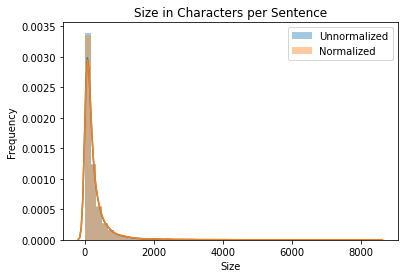

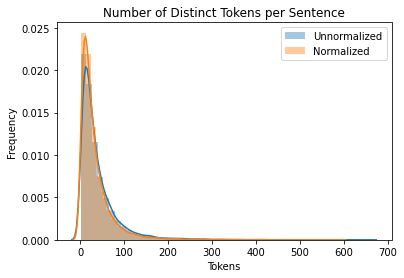

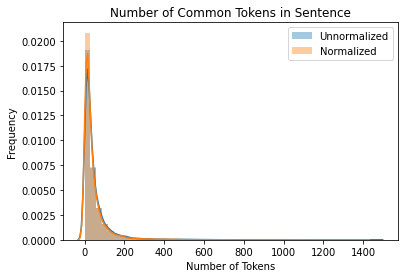

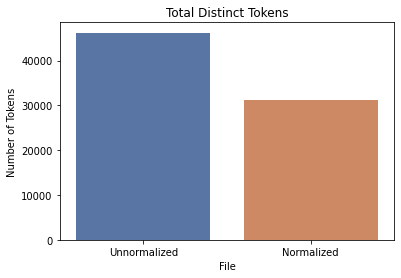

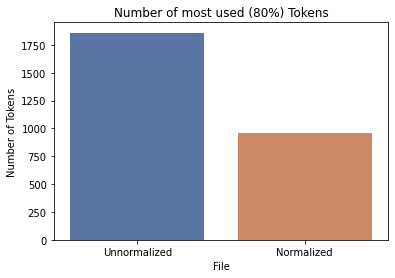

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
#Size in Characters
sns.distplot(unorm_df['Size_in_Chars'], label='Unnormalized')
sns.distplot(norm_df['Size_in_Chars'], label='Normalized')
plt.legend(loc='upper right')
plt.title('Size in Characters per Sentence')
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.savefig('size_chars.png')
plt.show()
#Distinct Tokens
sns.distplot(unorm_df['Num_distinct_Tokens'], label='Unnormalized')
sns.distplot(norm_df['Num_distinct_Tokens'], label='Normalized')
plt.legend(loc='upper right')
plt.title('Number of Distinct Tokens per Sentence')
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.savefig('num_tokens.png')
plt.show()
#Number of common Tokens in Sentence
sns.distplot(unorm_df['Common_tokens'], label='Unnormalized')
sns.distplot(norm_df['Common_tokens'], label='Normalized')
plt.legend(loc='upper right')
plt.title('Number of Common Tokens in Sentence')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.savefig('common_tokens.png')
plt.show()
#Total Number of Distinct Tokens
sns.barplot(x=["Unnormalized","Normalized"],y=[len(distinct_words_unorm), len(distinct_words_norm)], palette="deep")
plt.title('Total Distinct Tokens')
plt.xlabel('File')
plt.ylabel('Number of Tokens')
plt.savefig('total_distinct_tokens.png')
plt.show()
#Total Number of Most Used Tokens (80%)
sns.barplot(x=["Unnormalized","Normalized"],y=[len(most_used_words_unorm), len(most_used_words_norm)], palette="deep")
plt.title('Number of most used (80%) Tokens')
plt.xlabel('File')
plt.ylabel('Number of Tokens')
plt.savefig('most_used_tokens.png')
plt.show()


In [ ]:
print(unorm_df.head())
print(norm_df.head())
print(df.head())


                                                Text  ... Uncommon_tokens
0  A subsection of retarded Hungarians? Ohh boy. ...  ...               9
1  Hiii. Just got off work. 444 is mainly the typ...  ...              13
2  wow i guess soyboys are the same in every country  ...               2
3  Owen Benjamin's soyboy song goes for every cou...  ...               4
4  wouldn't the defenders or whatever they are as...  ...               9

[5 rows x 7 columns]
                                                Text  ... Uncommon_tokens
0  a subsection of retarded Hungarians Och boy br...  ...               9
1  Iii just get off work 444 be mainly the type g...  ...              10
2    wow i guess cowboy be the same in every country  ...               1
3  Owen Benjamins cowboy song go for every countr...  ...               5
4  would not the defender or whatever -PRON- be a...  ...              12

[5 rows x 7 columns]
                                                body  is_hate
0  A s